[View in Colaboratory](https://colab.research.google.com/github/TonyIssacJames/EIP_public/blob/master/DNST_CIFAR10_AUG.ipynb)

In [1]:
# https://keras.io/
#!pip install -q keras
import keras

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import keras
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Concatenate
from keras.optimizers import Adam

In [3]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf
from keras import backend as k

# Don't pre-allocate memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

In [32]:
# Hyperparameters
batch_size = 128
num_classes = 10
epochs = 50
l = 20
num_filter = 20
compression = 0.6
dropout_rate = 0.20

In [33]:
# Load CIFAR10 Data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]

# convert to one hot encoing 
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [34]:
import numpy as np

x_train = np.append(x_train, x_train,axis=0)
y_train = np.append(y_train, y_train,axis=0)
print(x_train.shape)
#print(np.append(x_train, x_train,axis=0).shape)
#print(np.append(y_train, y_train,axis=0).shape)
print(y_train.shape)

(100000, 32, 32, 3)
(100000, 10)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  if __name__ == '__main__':


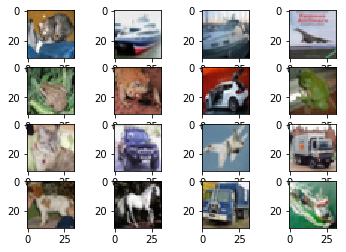

In [35]:
from matplotlib import pyplot
from scipy.misc import toimage
def show_imgs(X):
    pyplot.figure(1)
    k = 0
    for i in range(0,4):
        for j in range(0,4):
            pyplot.subplot2grid((4,4),(i,j))
            pyplot.imshow(toimage(X[k]))
            k = k+1
    # show the plot
    pyplot.show()

show_imgs(x_test[:16])

In [36]:
print(y_test[:16])

[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


In [37]:
#Data Augmentation
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=40,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,    # randomly flip images
        fill_mode='nearest')

In [38]:
#Callback for saving the best model
from keras.callbacks import ModelCheckpoint
filepath= "weights_tr_05_v2.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [39]:
# Dense Block
def add_denseblock(input, num_filter = 20, dropout_rate = 0.2):
    global compression
    temp = input
    for _ in range(l):
        BatchNorm = BatchNormalization()(temp)
        relu = Activation('relu')(BatchNorm)
        Conv2D_3_3 = Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
          Conv2D_3_3 = Dropout(dropout_rate)(Conv2D_3_3)
        concat = Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

In [40]:
def add_transition(input, num_filter = 20, dropout_rate = 0.2):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
      Conv2D_BottleNeck = Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    
    return avg

In [41]:
def output_layer(input):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    AvgPooling = AveragePooling2D(pool_size=(2,2))(relu)
    flat = Flatten()(AvgPooling)
    output = Dense(num_classes, activation='softmax')(flat)
    
    return output

In [42]:
#num_filter = 16
#Sdropout_rate = 0.2
#l = 12
input = Input(shape=(img_height, img_width, channel,))
First_Conv2D = Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = add_denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = add_transition(First_Block, num_filter, dropout_rate)

Second_Block = add_denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = add_transition(Second_Block, num_filter, dropout_rate)

Third_Block = add_denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = add_transition(Third_Block, num_filter, dropout_rate)

Fourth_Block = add_denseblock(Third_Transition, num_filter, dropout_rate)
Fourth_Transition = add_transition(Fourth_Block, num_filter, dropout_rate)

#Fifth_Block = add_denseblock(Fourth_Transition, num_filter, dropout_rate)
#Fifth_Transition = add_transition(Fifth_Block, num_filter, dropout_rate)

Last_Block = add_denseblock(Fourth_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)


In [43]:
model = Model(inputs=[input], outputs=[output])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_221 (Conv2D)             (None, 32, 32, 20)   540         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_221 (BatchN (None, 32, 32, 20)   80          conv2d_221[0][0]                 
__________________________________________________________________________________________________
activation_221 (Activation)     (None, 32, 32, 20)   0           batch_normalization_221[0][0]    
__________________________________________________________________________________________________
conv2d_222

In [45]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [ ]:
'''model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=callbacks_list)'''

model.fit_generator(datagen.flow(x_train, y_train,
                    batch_size=batch_size),
                    epochs=5,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=callbacks_list)

Epoch 1/5
183/782 [======>.......................] - ETA: 12:39 - loss: 2.0413 - acc: 0.2293

In [19]:
# Test the model
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 18s 2ms/step
Test loss: 0.5077479893147946
Test accuracy: 0.8528


In [20]:
# Save the trained weights in to .h5 format
model.save_weights("DNST_model_tr_05_v2.h5")
print("Saved model to disk")

Saved model to disk


In [22]:
from keras.models import load_model

new_model = load_model("weights_tr_05_v2.best.hdf5")
score = new_model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 22s 2ms/step
Test loss: 0.41088400869369507
Test accuracy: 0.872


In [0]:
#from google.colab import files

#files.download('DNST_model.h5')